In [50]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Utils'), '..')))
from Utils.data_utils import load_preprocessed_data_from_folder

# Load the data from the CSV file into a pandas DataFrame
data = load_preprocessed_data_from_folder()

data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.502784,0.571139,0.336096,0.543891,0.680385,0.669439,0.313402,0.699753,0.286091,0.0
1,0.265434,0.297400,0.300611,0.491839,0.602571,0.719411,0.497319,0.450999,0.576793,0.0
2,0.578509,0.641311,0.321619,0.698543,0.563298,0.414652,0.562017,0.532866,0.303637,0.0
3,0.594055,0.605536,0.356244,0.603314,0.647347,0.317880,0.622089,0.808065,0.601015,0.0
4,0.649445,0.484851,0.289922,0.484900,0.514545,0.379337,0.358555,0.253606,0.496327,0.0
...,...,...,...,...,...,...,...,...,...,...
3991,0.560356,0.434710,0.215044,0.535173,0.515598,0.341800,0.578386,0.497830,0.644700,1.0
3992,0.369342,0.453484,0.419993,0.555453,0.659636,0.310077,0.418230,0.518917,0.459890,1.0
3993,0.514873,0.394047,0.550464,0.706030,0.415335,0.544953,0.446907,0.582838,0.610959,1.0
3994,0.500670,0.484272,0.490260,0.783886,0.364165,0.535721,0.349975,0.552053,0.439660,1.0


In [122]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
NUM_FOLDS = 5

train_df, test_df = train_test_split(data, test_size=TEST_SIZE)
train_df, test_df

(            ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
 915   0.439526  0.688115  0.356796     0.605753  0.503477      0.530926   
 3205  0.477293  0.656063  0.121241     0.437992  0.666240      0.127494   
 2005  0.494831  0.556918  0.203256     0.576265  0.755873      0.494075   
 7     0.616846  0.565593  0.219208     0.329629  0.495155      0.512581   
 1701  0.432472  0.655681  0.162461     0.440859  0.505061      0.454683   
 ...        ...       ...       ...          ...       ...           ...   
 2397  0.539702  0.518803  0.477631     0.588405  0.627641      0.599767   
 1695  0.451455  0.429427  0.331012     0.567825  0.639970      0.421183   
 2495  0.464897  0.493510  0.202853     0.737832  0.542199      0.526286   
 366   0.288378  0.885154  0.853738     0.581406  0.476033      0.384222   
 1628  0.483555  0.474804  0.273524     0.524438  0.684333      0.206207   
 
       Organic_carbon  Trihalomethanes  Turbidity  Potability  
 915         0.569933 

In [123]:
# bisect the data into features and target (potability)
train_x = train_df.drop('Potability', axis=1)
train_y = train_df['Potability']

test_x = test_df.drop('Potability', axis=1)
test_y = test_df['Potability']

In [124]:
# Naive random forest model

from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(train_x, train_y)

print(f'Random Forest test accuracy: {random_forest.score(test_x, test_y):0.2%}')

Random Forest test accuracy: 74.50%


In [125]:
from sklearn.model_selection import GridSearchCV

params = {
  'n_estimators': [100, 200],
  # 'max_depth': [None, 10, 20, 50],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4],
  'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(random_forest, params, scoring='f1', verbose=4, cv=NUM_FOLDS, n_jobs=-1)
grid_search.fit(train_x, train_y)

print(f'Random Forest test accuracy: {grid_search.score(test_x, test_y):0.2%}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Random Forest test accuracy: 76.25%


In [132]:
best_model = grid_search.best_estimator_
print(f'Best model: {best_model}, best params: {grid_search.best_params_}')

print(f'Best model score: {best_model.score(test_x, test_y):0.2%}')

Best model: RandomForestClassifier(n_estimators=200), best params: {'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best model score: 75.62%


In [137]:
from sklearn.calibration import CalibratedClassifierCV

ideal_rf = RandomForestClassifier(**grid_search.best_params_)

calibrated_rf = CalibratedClassifierCV(ideal_rf, cv=NUM_FOLDS)
calibrated_rf.fit(train_x, train_y)

print(f'Calibrated Random Forest test accuracy: {calibrated_rf.score(test_x, test_y):0.2%}')

Calibrated Random Forest test accuracy: 75.38%


In [138]:
calibrated_rf.predict_proba(test_x)

array([[0.18423024, 0.81576976],
       [0.13554899, 0.86445101],
       [0.55956193, 0.44043807],
       ...,
       [0.17308201, 0.82691799],
       [0.93982354, 0.06017646],
       [0.36190254, 0.63809746]])

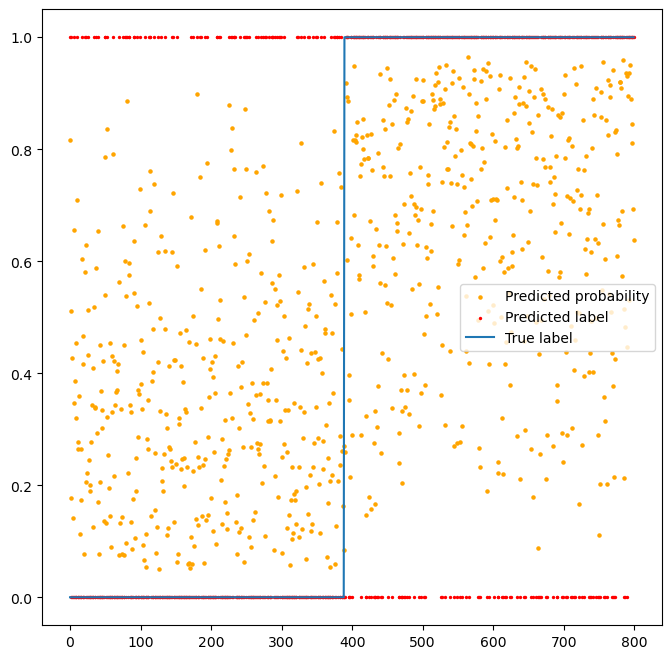

In [139]:
import matplotlib.pyplot as plt
import numpy as np

# Create a zipped array of sample index, predicted proability and true label
results = np.column_stack((calibrated_rf.predict_proba(test_x)[:, 1], calibrated_rf.predict(test_x), test_y))

# Sort by true label
results = results[results[:, 2].argsort()]

# Plot the predicted probabilities & true labels

plt.figure(figsize=(8, 8))
plt.scatter(range(len(results)), results[:, 0], label='Predicted probability', c='orange', s=5)
plt.scatter(range(len(results)), results[:, 1], label='Predicted label', c='red', s=2)
plt.plot(results[:, 2], label='True label')
plt.legend()

plt.show()


